In [2]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow import keras

In [3]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-08-10 04:02:28--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.53.252.195, 2600:1406:3f:384::e59, 2600:1406:3f:3a0::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.53.252.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   113MB/s    in 7.2s    

2021-08-10 04:02:35 (109 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [4]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [5]:
create_dir_list=[
                 '/tmp/cats-v-dogs',
                 '/tmp/cats-v-dogs/training',
                 '/tmp/cats-v-dogs/testing',
                 '/tmp/cats-v-dogs/training/cats',
                 '/tmp/cats-v-dogs/training/dogs',
                 '/tmp/cats-v-dogs/testing/cats',
                 '/tmp/cats-v-dogs/testing/dogs'
]

In [6]:
for dirs in create_dir_list:
  try:
    os.mkdir(dirs)
    print(dirs,' created!')
  except:
    print(dirs,' failed!')

/tmp/cats-v-dogs  created!
/tmp/cats-v-dogs/training  created!
/tmp/cats-v-dogs/testing  created!
/tmp/cats-v-dogs/training/cats  created!
/tmp/cats-v-dogs/training/dogs  created!
/tmp/cats-v-dogs/testing/cats  created!
/tmp/cats-v-dogs/testing/dogs  created!


In [7]:
def split_data(src,training,testing,split):
    files = []
    
    for file_name in os.listdir(src):
        file_path = src + file_name

        if os.path.getsize(file_path):
            files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    nfiles = len(files)
    splitpt=int(nfiles*split)
    
    shuffled=random.sample(files,nfiles)
    train_set = shuffled[:splitpt]
    test_set = shuffled[splitpt:]
    
    for file_name in train_set:
        copyfile(src+file_name,training+file_name)
        
    for file_name in test_set:
        copyfile(src+file_name,testing+file_name)

In [8]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

In [9]:
split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


In [10]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [11]:
model=tf.keras.Sequential([
                           tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
                           tf.keras.layers.MaxPool2D(2,2),
                           tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
                           tf.keras.layers.MaxPool2D(2,2),
                           tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                           tf.keras.layers.MaxPool2D(2,2),
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(512,activation='relu'),
                           tf.keras.layers.Dense(1,activation='sigmoid')                          
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [14]:
model.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
TRAINING_DIR='/tmp/cats-v-dogs/training'
train_datagen=ImageDataGenerator(rescale=1/255.0)
train_generator=train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=64,
    target_size=(150,150),
    class_mode='binary'
)

VALIDATION_DIR='/tmp/cats-v-dogs/testing'
validation_datagen=ImageDataGenerator(rescale=1/255.0)
validation_generator= validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=64,
    target_size=(150,150),
    class_mode='binary'
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [16]:
history=model.fit(train_generator,epochs=15,verbose=1,validation_data=validation_generator)

Epoch 1/15
177/352 [==============>...............] - ETA: 34s - loss: 0.6715 - accuracy: 0.6177

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 [==============================] - 107s 213ms/step - loss: 0.6145 - accuracy: 0.6631 - val_loss: 0.4874 - val_accuracy: 0.7640
Epoch 2/15
352/352 [==============================] - 75s 213ms/step - loss: 0.4751 - accuracy: 0.7740 - val_loss: 0.4484 - val_accuracy: 0.7884
Epoch 3/15
352/352 [==============================] - 75s 212ms/step - loss: 0.3964 - accuracy: 0.8195 - val_loss: 0.4295 - val_accuracy: 0.8072
Epoch 4/15
352/352 [==============================] - 74s 211ms/step - loss: 0.3282 - accuracy: 0.8565 - val_loss: 0.4273 - val_accuracy: 0.8020
Epoch 5/15
352/352 [==============================] - 74s 209ms/step - loss: 0.2557 - accuracy: 0.8922 - val_loss: 0.4460 - val_accuracy: 0.8148
Epoch 6/15
352/352 [==============================] - 74s 211ms/step - loss: 0.1936 - accuracy: 0.9229 - val_loss: 0.4891 - val_accuracy: 0.8244
Epoch 7/15
352/352 [==============================] - 74s 212ms/step - loss: 0.1375 - accuracy: 0.9470 - val_loss: 0.6936 - val_accuracy: 0.

Text(0.5, 1.0, 'Training and validation loss')

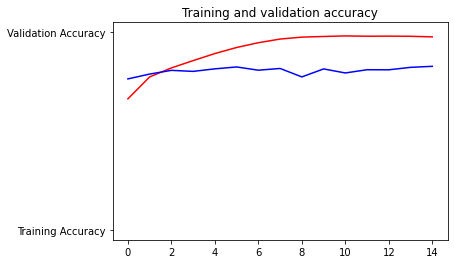

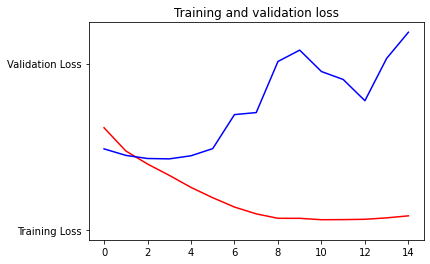

In [17]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')


In [19]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving puppy-1903313_1920.jpg to puppy-1903313_1920.jpg
Saving cat-1192026_1920.jpg to cat-1192026_1920 (1).jpg
Saving husky-3380548_1920.jpg to husky-3380548_1920 (1).jpg
[1.]
puppy-1903313_1920.jpg is a dog
[0.]
cat-1192026_1920.jpg is a cat
[0.]
husky-3380548_1920.jpg is a cat
